# Maciej Adamus GSN

In [8]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Dane

In [9]:
imdb_dir = 'data-imdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding ="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [10]:
def prepare_data(data = texts, labels = labels, training_samples: int = 2000, validation_samples: int = 10000, num_words: int = 10000 , maxlen: int = 200):
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    # print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=maxlen)

    labels = np.asarray(labels)
    # print('Shape of data tensor:', data.shape)
    # print('Shape of label tensor:', labels.shape)

    # Split the data into a training set and a validation set, but first, shuffle the data,
    # since we started from data where sample are ordered (all negative first, then all positive).
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]

    x_train = data[:training_samples]
    y_train = labels[:training_samples]
    x_val = data[training_samples: training_samples + validation_samples]
    y_val = labels[training_samples: training_samples + validation_samples]

    return x_train, y_train, x_val, y_val, word_index

### Ładowanie embeddingu GloVe

In [11]:
def load_glove_embeddings_from_file(embedding_dim: int = 200, glove_dir: str = 'glove'):
    embedding_index = {}
    with open(os.path.join(glove_dir, f'glove.6B.{embedding_dim}d.txt'), encoding ="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs

    # print(f'Found {len(embedding_index)} word vectors.')
    return embedding_index

def create_embedding_matrix(embedding_index, embedding_dim, n_top_words, word_index):
    embedding_maxtrix = np.zeros((n_top_words, embedding_dim))
    for word, i in word_index.items():
        if i < n_top_words:
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                embedding_maxtrix[i] = embedding_vector
    return embedding_maxtrix

In [13]:
embedding_index = {
    50: load_glove_embeddings_from_file(50),
    100: load_glove_embeddings_from_file(100),
    200: load_glove_embeddings_from_file(200),
    300: load_glove_embeddings_from_file(300)
}

### Tworzenie i trenowanie modeli

Przetestujemy różne modele. Modele będą różnić się 3 głównymi parametrami:
- ilością próbek treningowych
- maksymalną długością sekwencji (pierwsze n słów z recenzji)
- wymiarem embeddingu

Do tego wykorzystamy funkcję `create_and_train_model`, która tworzy model, trenuje go i zwraca historię trenowania. 

In [12]:
def create_and_train_model(embedding_dim: int , n_top_words: int = 10000, maxlen: int = 200, training_samples: int = 2000, epochs: int = 30):
    x_train, y_train, x_val, y_val, word_index = prepare_data(data=texts, labels=labels, training_samples=training_samples, num_words=n_top_words, maxlen=maxlen)
    
    embedding_matrix = create_embedding_matrix(embedding_index[embedding_dim], embedding_dim, n_top_words, word_index)

    model = Sequential(name=f'embedding-{embedding_dim}_samples-{training_samples}_maxlen-{maxlen}')
    model.add(Embedding(n_top_words, embedding_dim, weights=embedding_matrix))
    # model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    history = model.fit(x_train, y_train, epochs=epochs, batch_size=32, validation_data=(x_val, y_val))
    return model, history

In [14]:
models = []
histories = []

for n_training_samples in [2000, 5000, 10000, 15000]:
    for maxlen in [100, 200, 300]:
        for embedding_dim in [50, 100, 200, 300]:
            model, history = create_and_train_model(embedding_dim=embedding_dim, training_samples=n_training_samples, epochs=30, maxlen=maxlen)
            models.append(model)
            histories.append(history)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.5460 - loss: 0.7647 - val_acc: 0.6149 - val_loss: 0.6954
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7129 - loss: 0.6188 - val_acc: 0.6105 - val_loss: 0.7201
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8010 - loss: 0.4781 - val_acc: 0.6394 - val_loss: 0.7098
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8544 - loss: 0.3986 - val_acc: 0.6421 - val_loss: 0.7157
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8974 - loss: 0.3375 - val_acc: 0.6410 - val_loss: 0.7549
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9052 - loss: 0.3074 - val_acc: 0.6224 - val_loss: 0.8412
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9037 - loss: 0.2787 - val_acc: 0.6348 - val_loss: 0.8245
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9235 - loss: 0.2502 - val_acc: 0.6372 - val_loss: 0.8496
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9453 - loss:

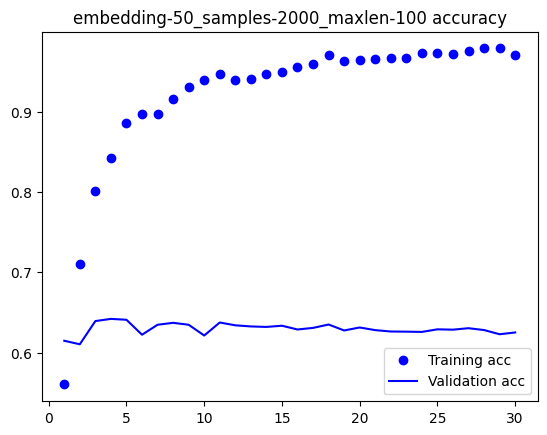

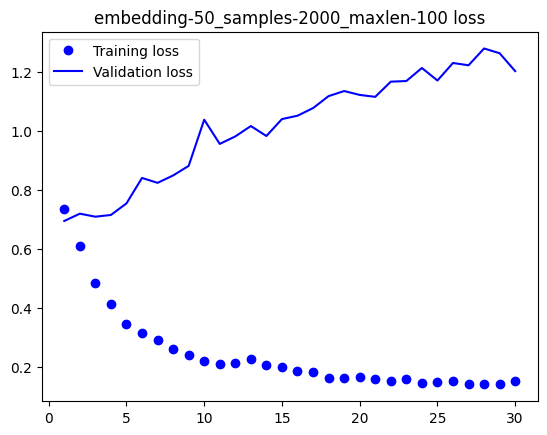

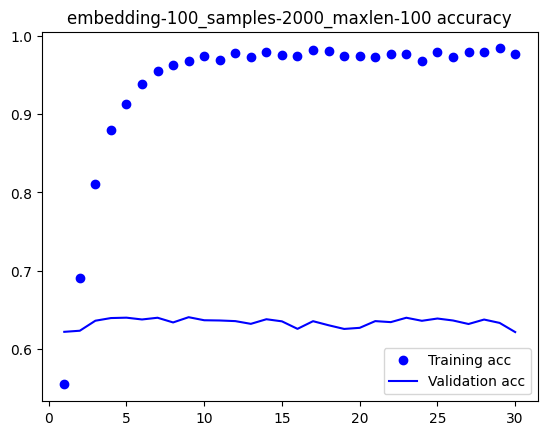

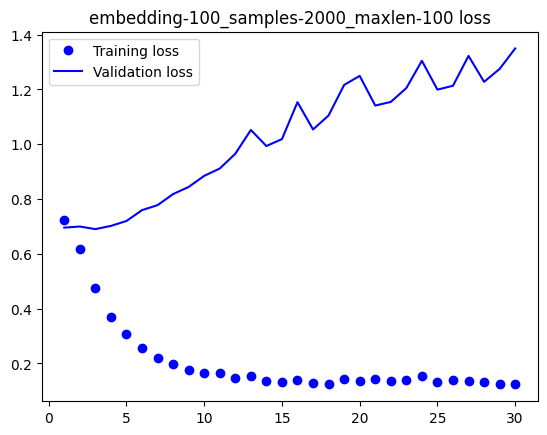

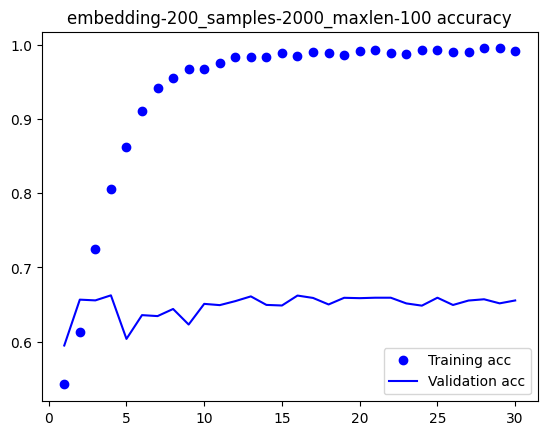

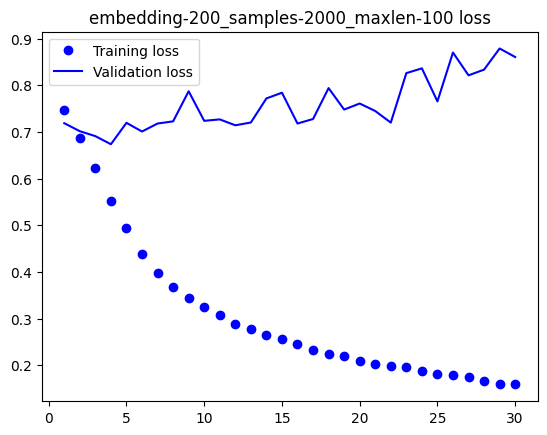

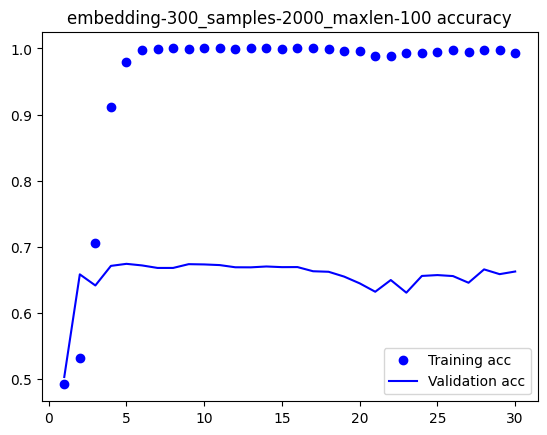

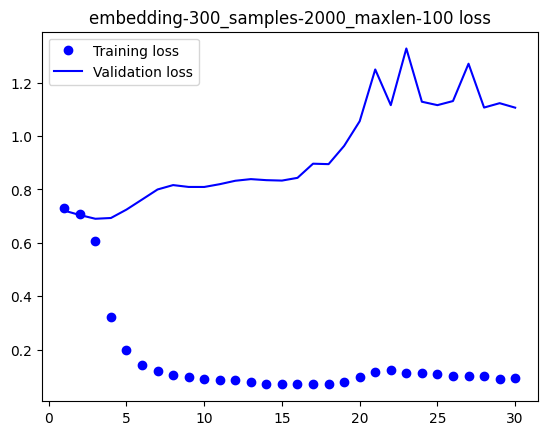

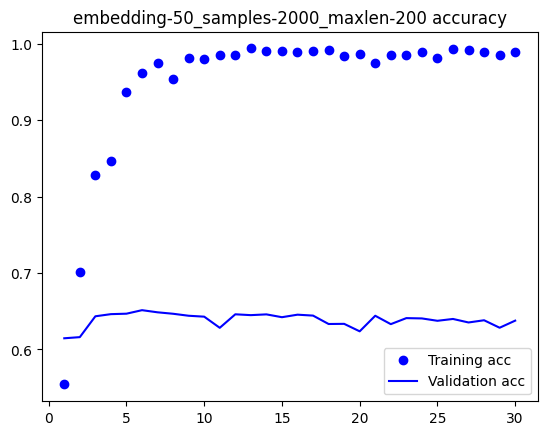

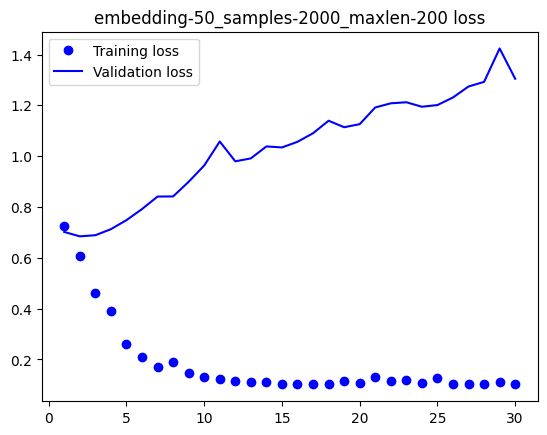

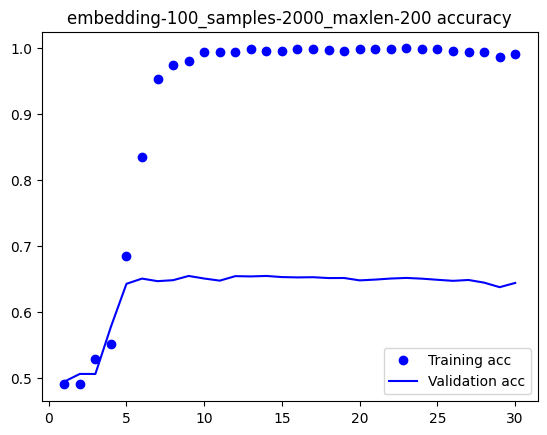

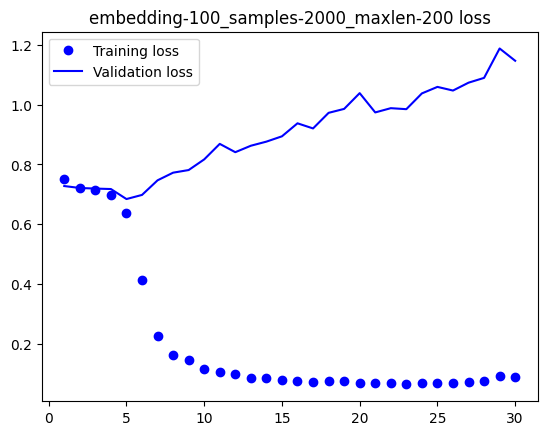

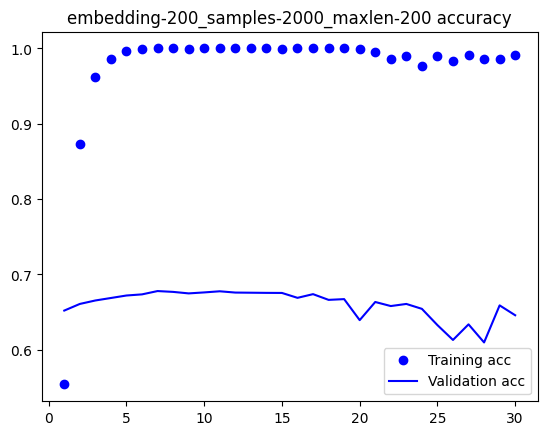

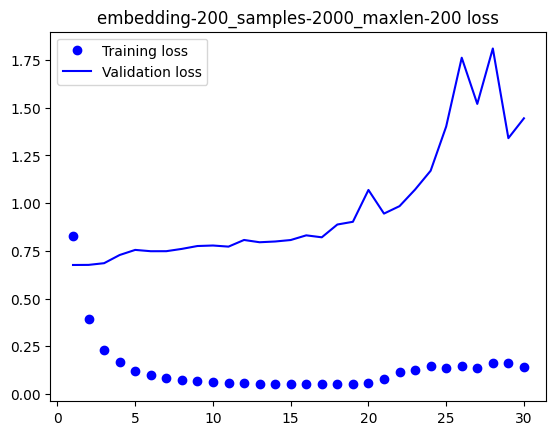

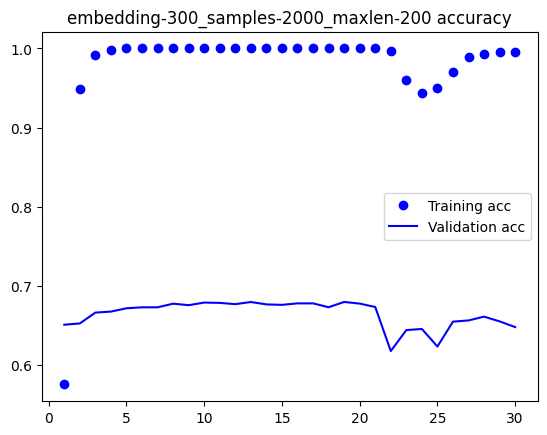

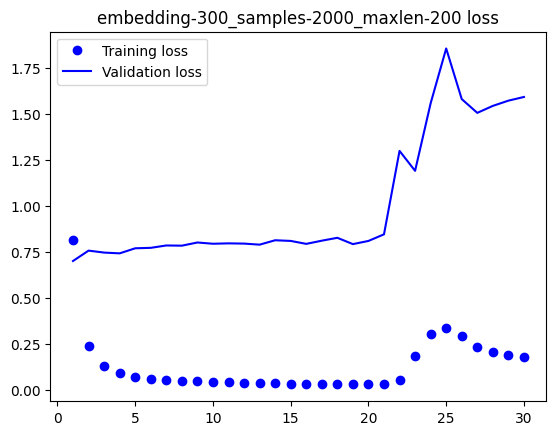

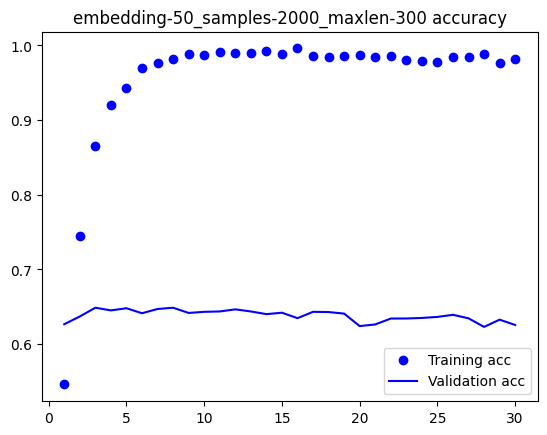

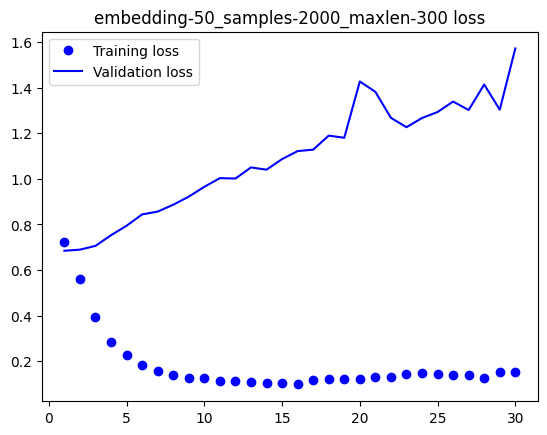

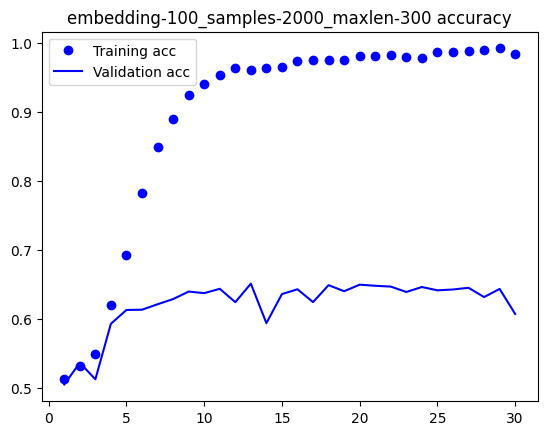

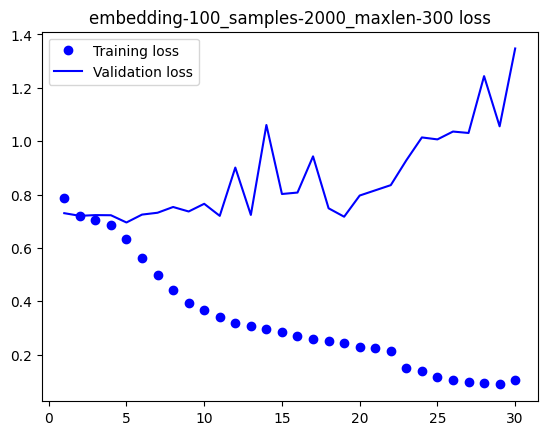

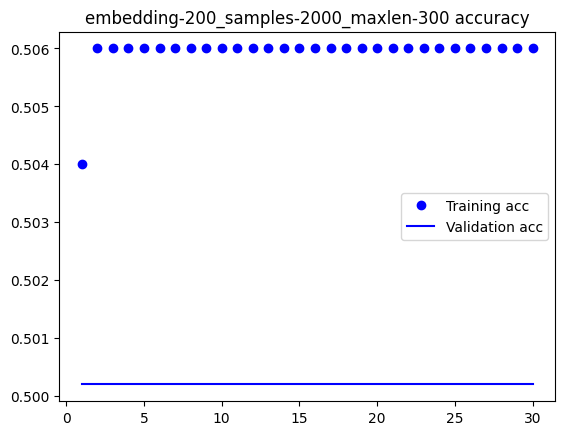

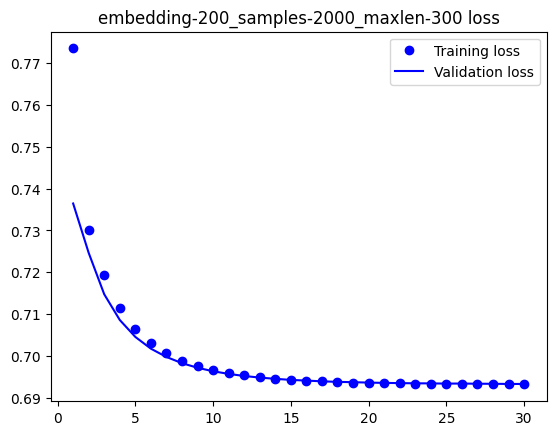

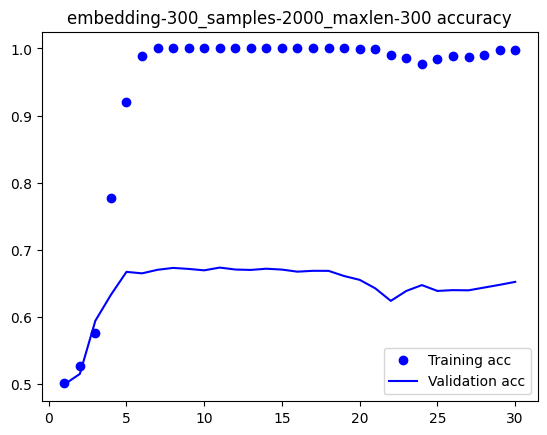

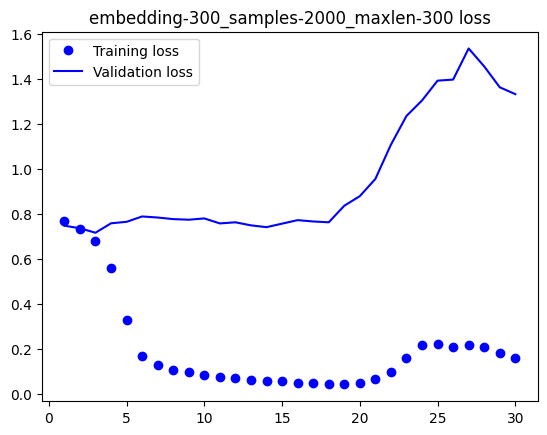

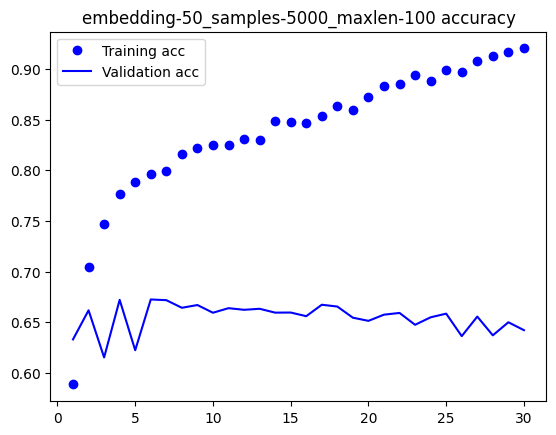

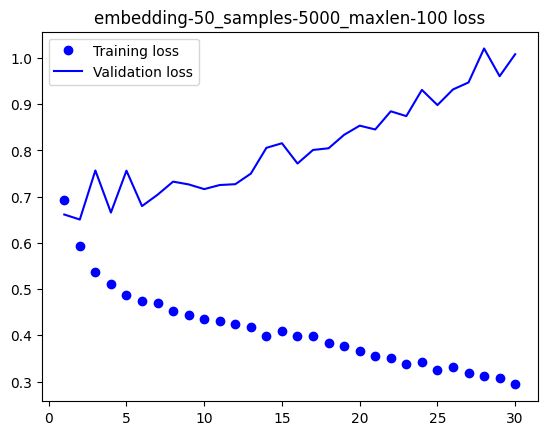

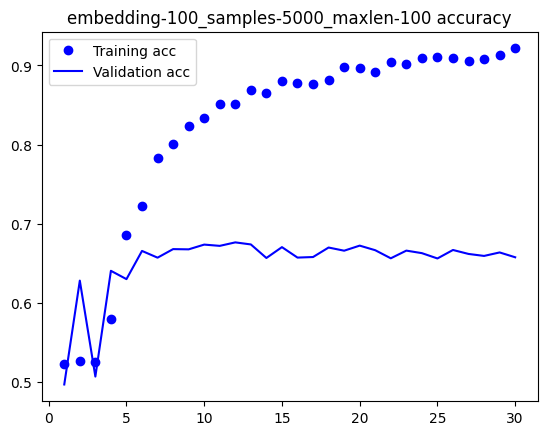

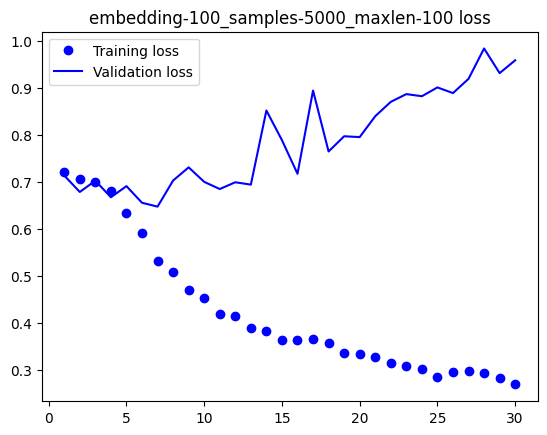

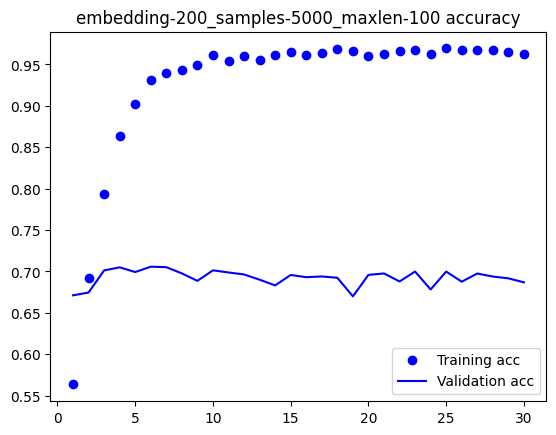

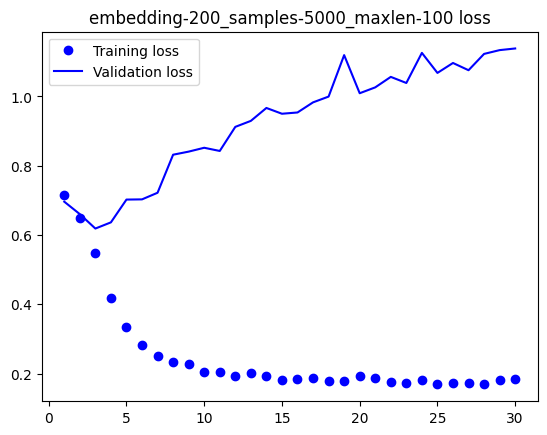

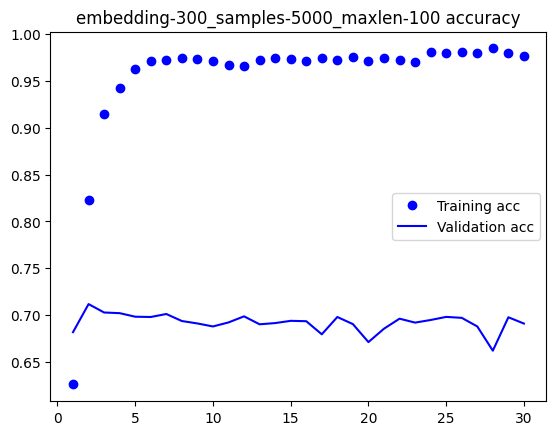

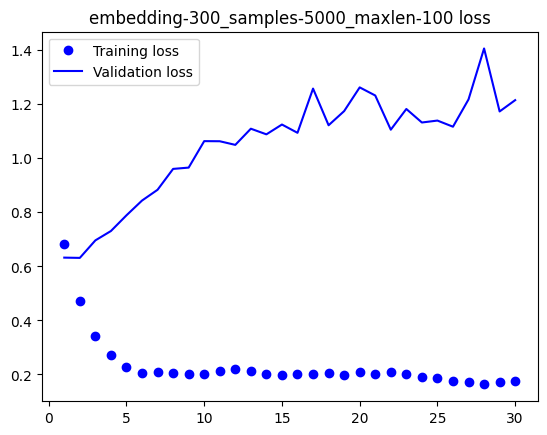

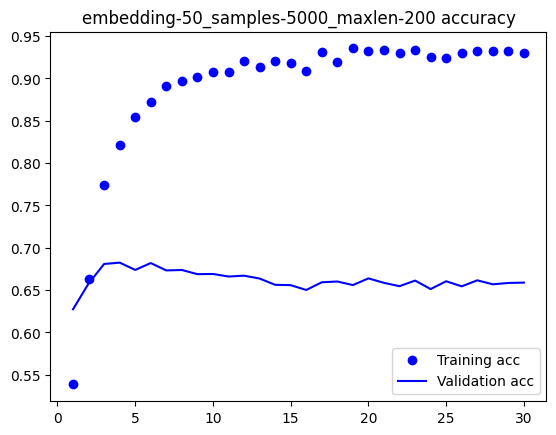

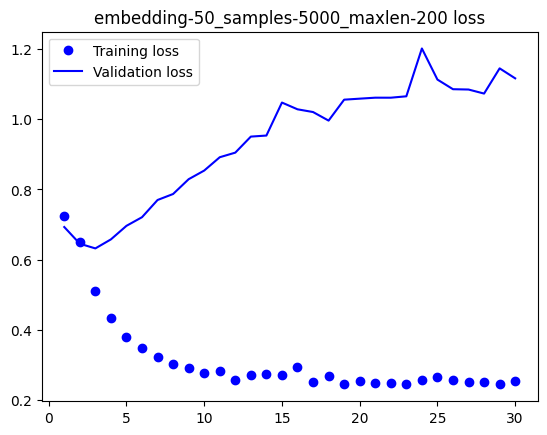

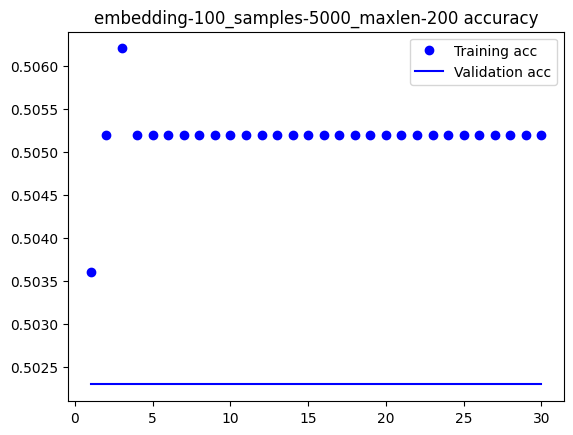

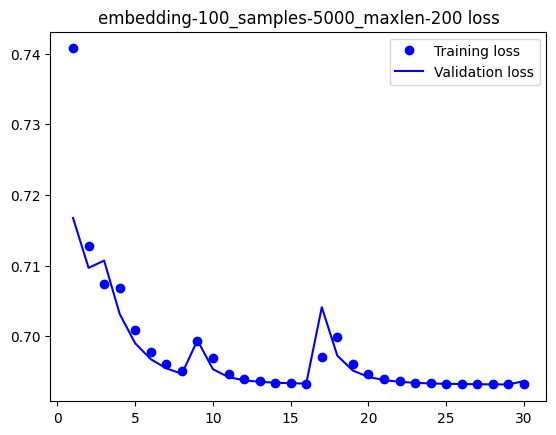

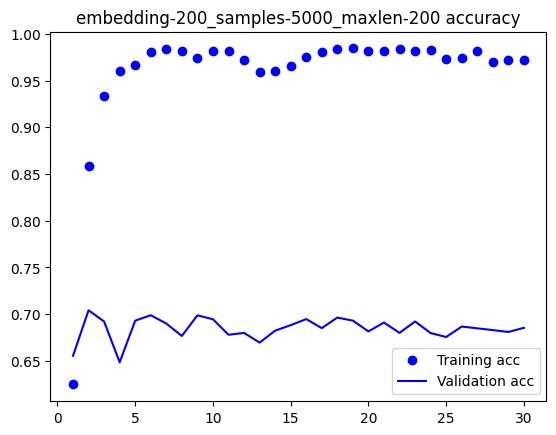

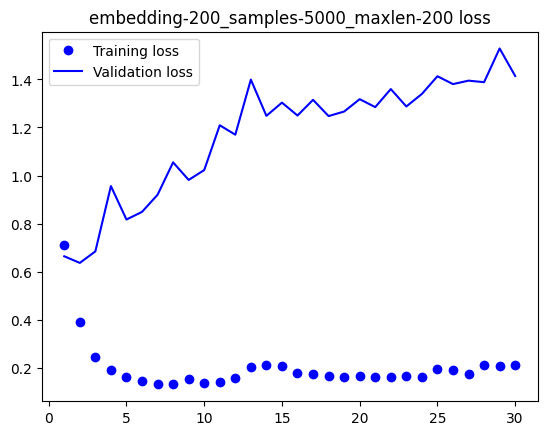

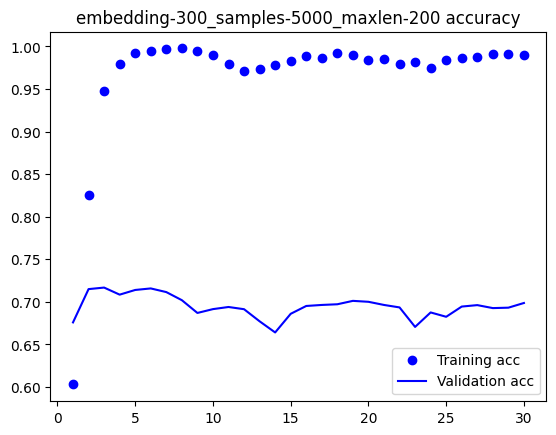

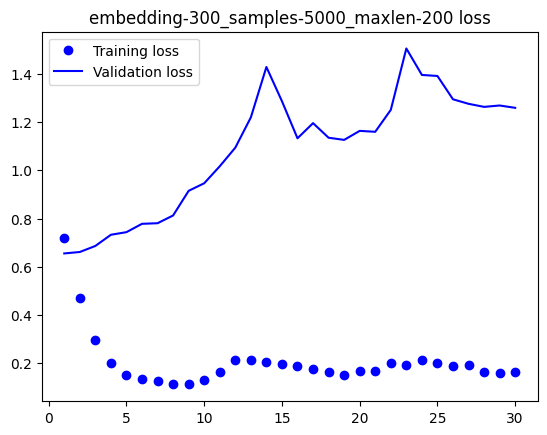

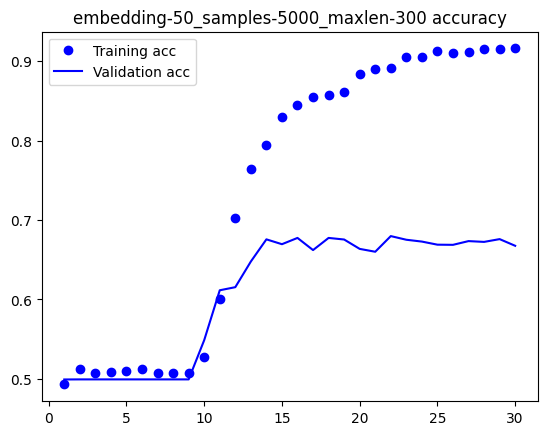

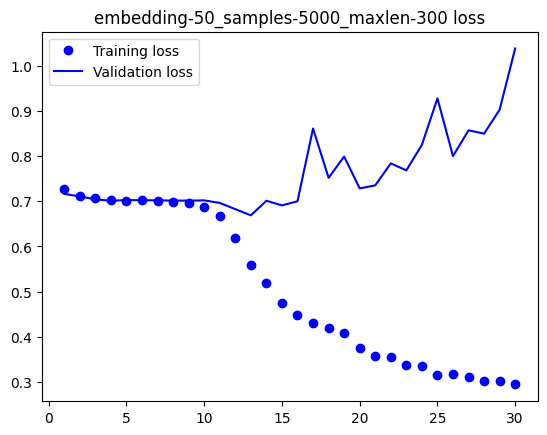

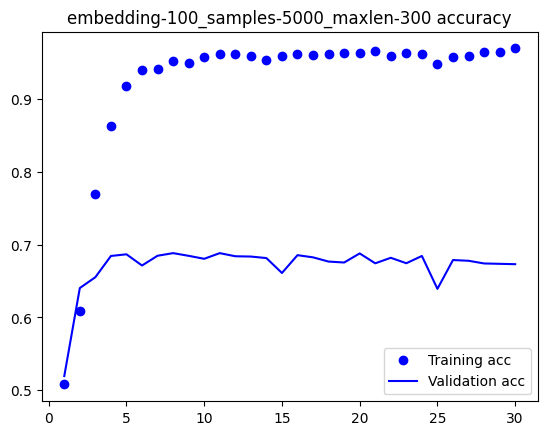

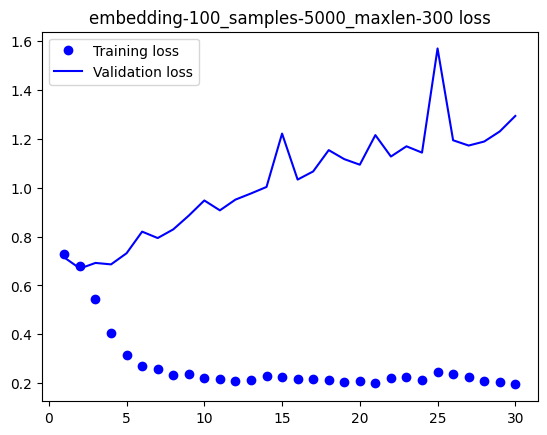

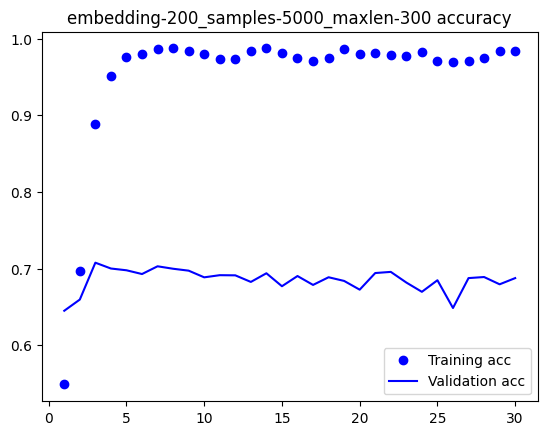

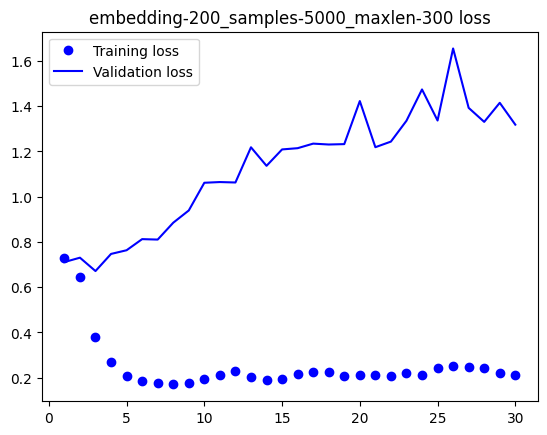

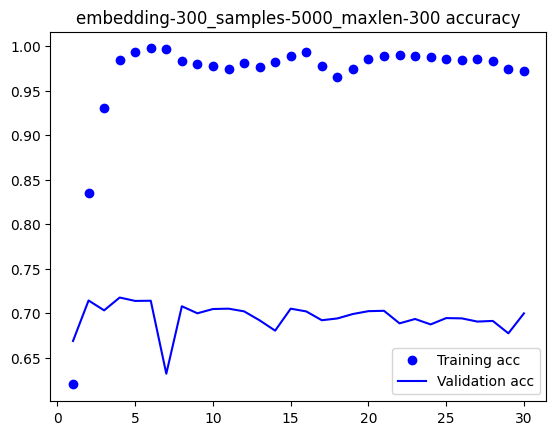

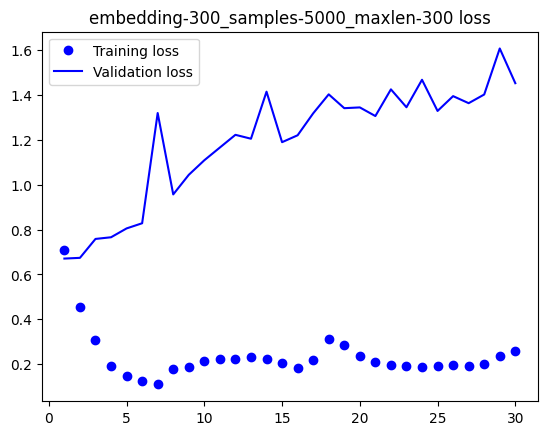

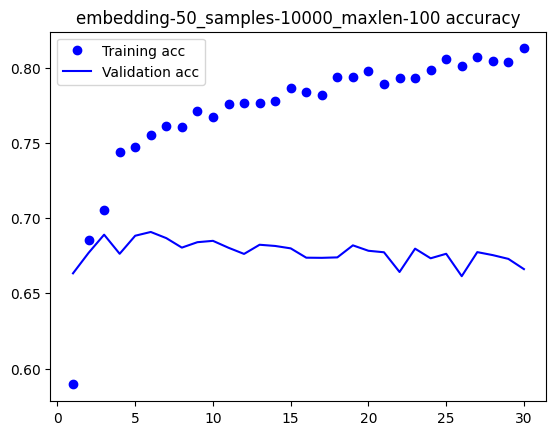

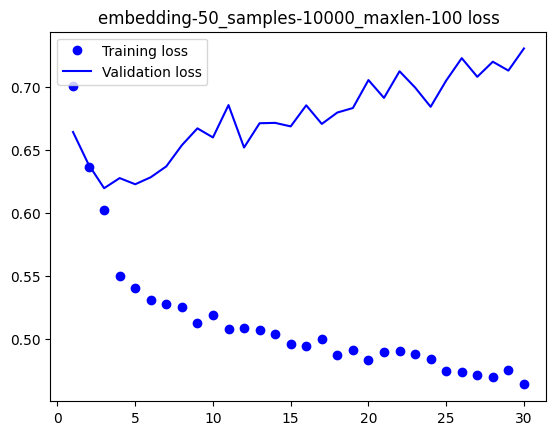

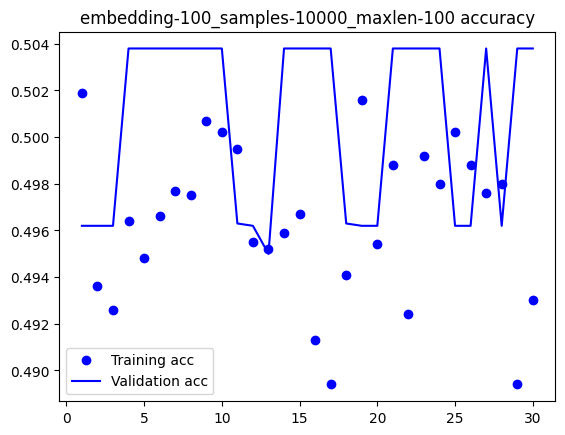

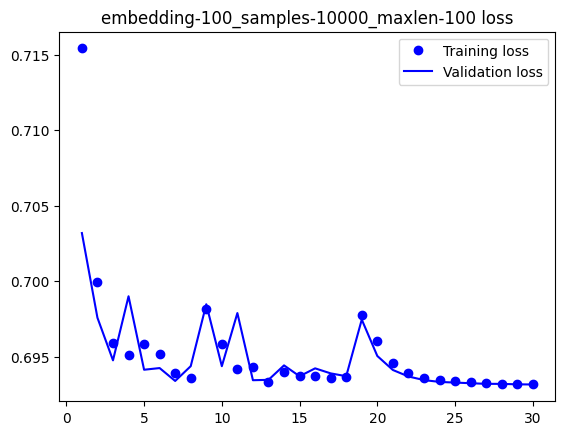

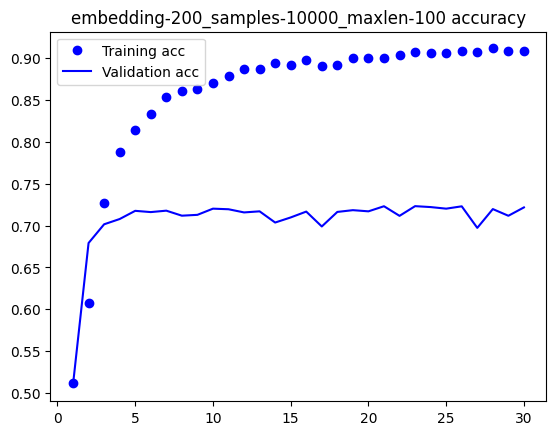

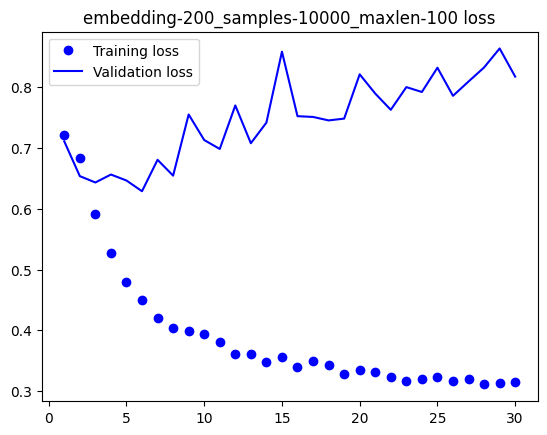

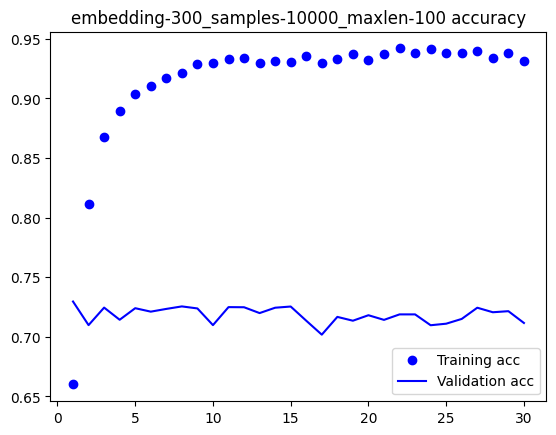

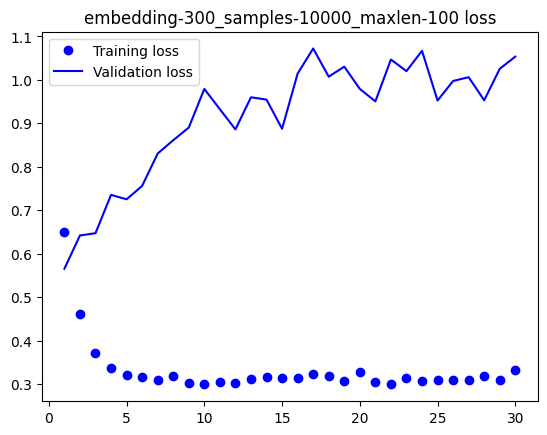

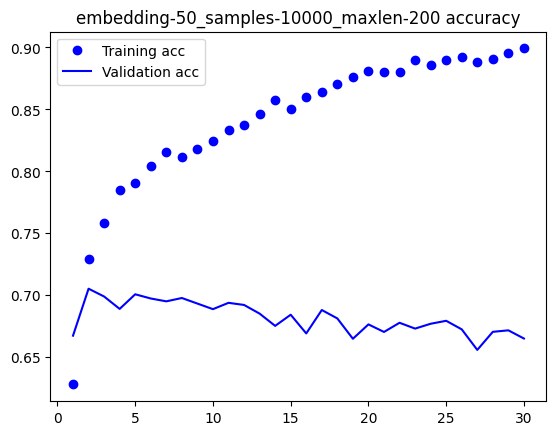

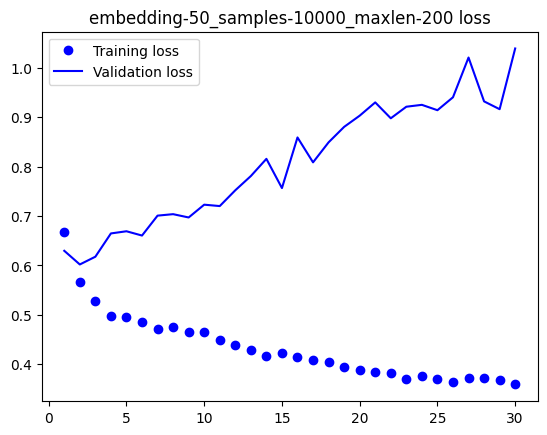

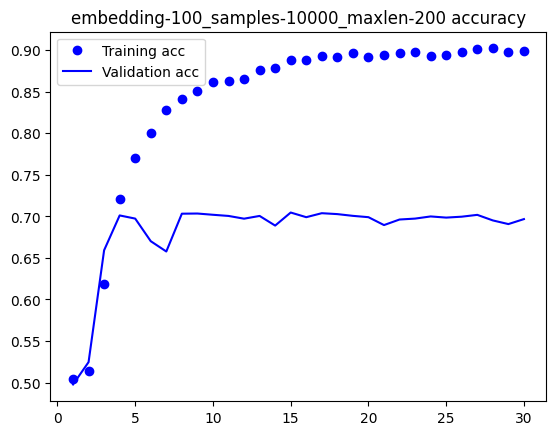

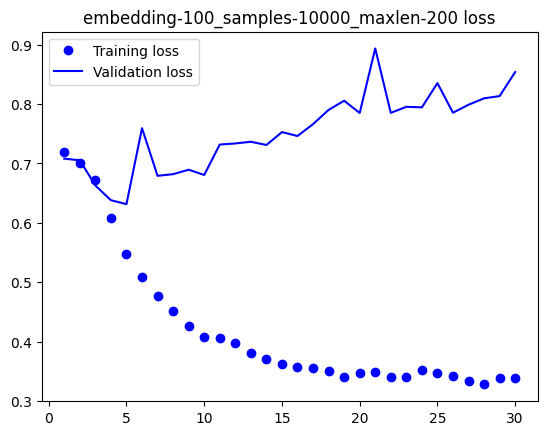

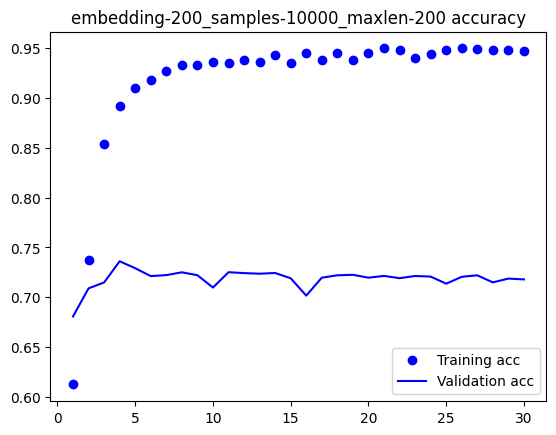

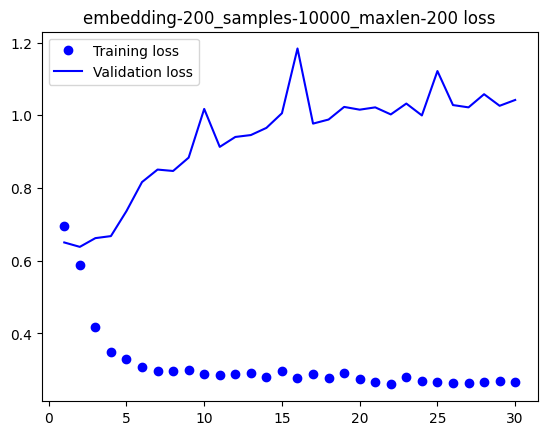

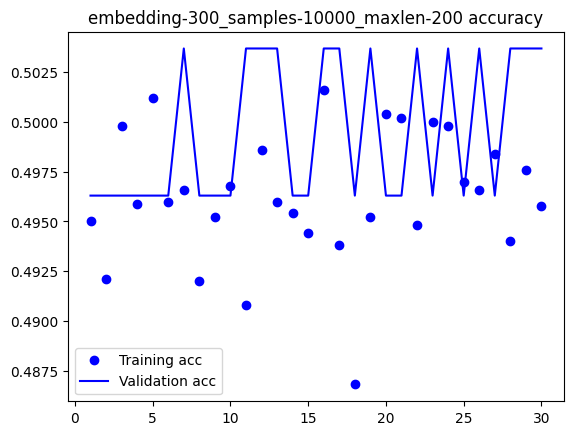

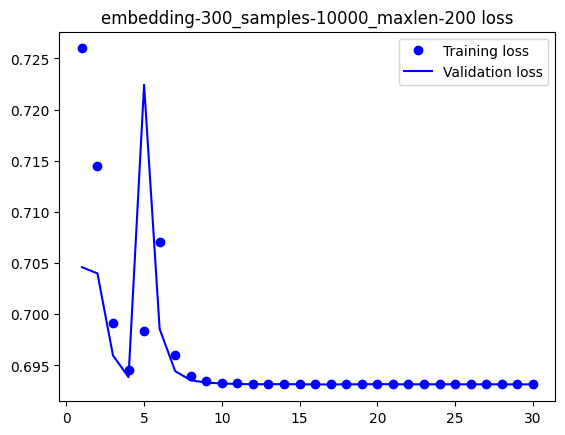

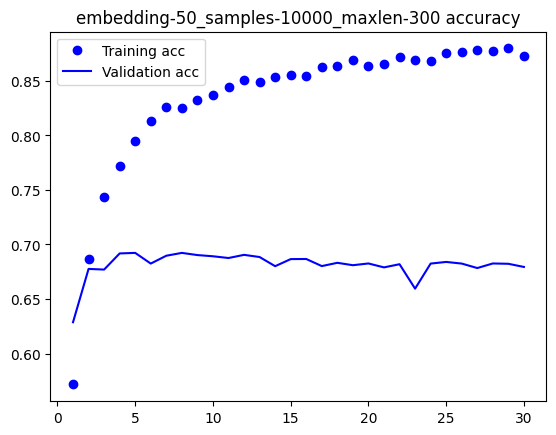

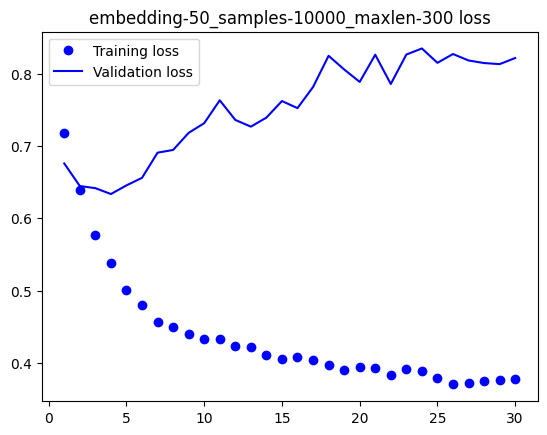

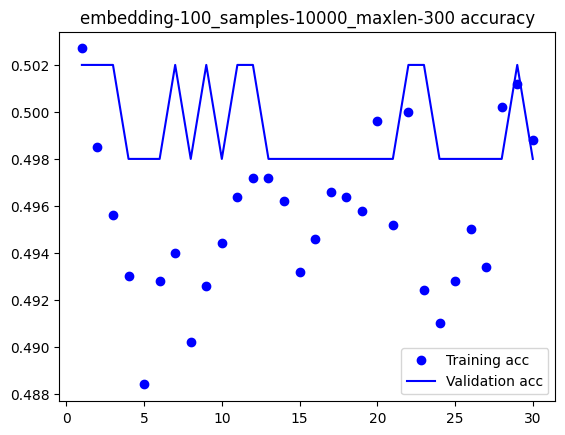

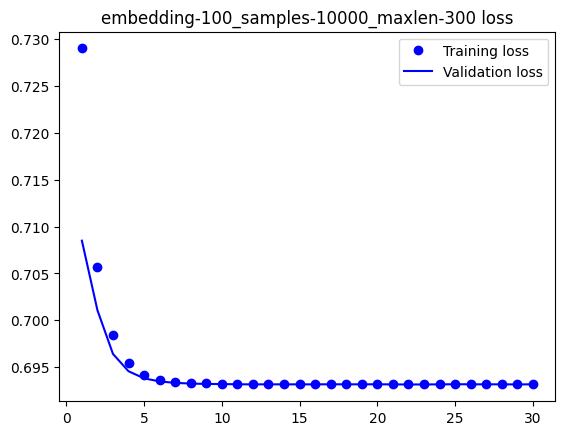

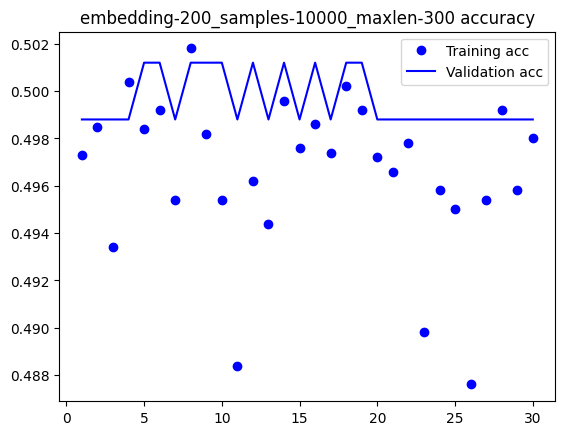

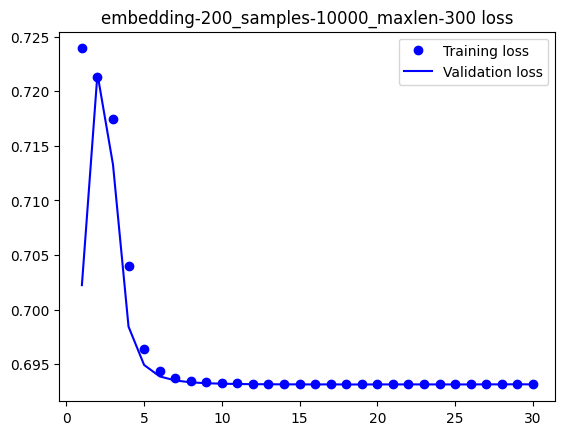

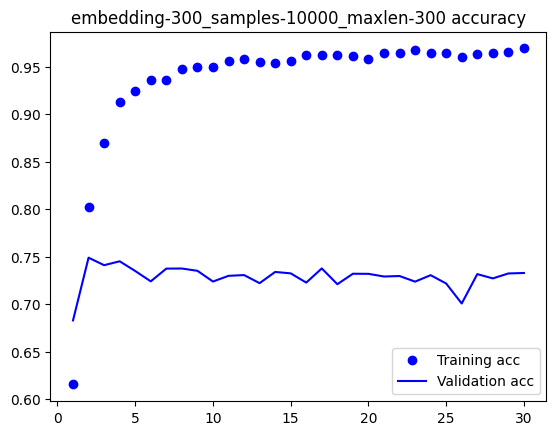

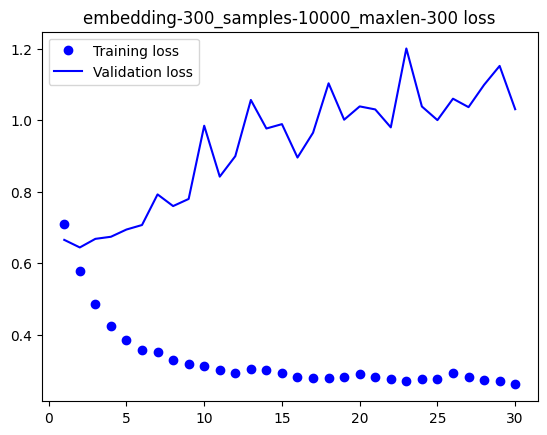

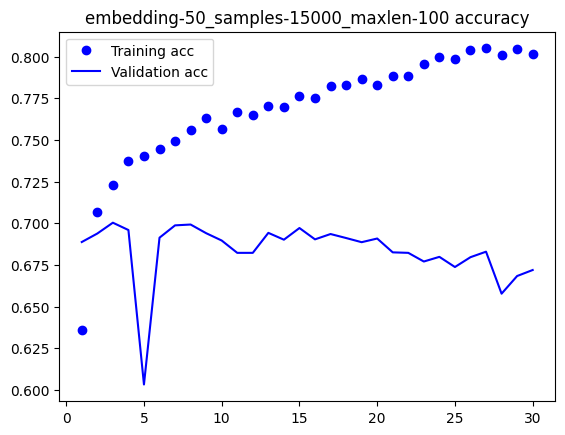

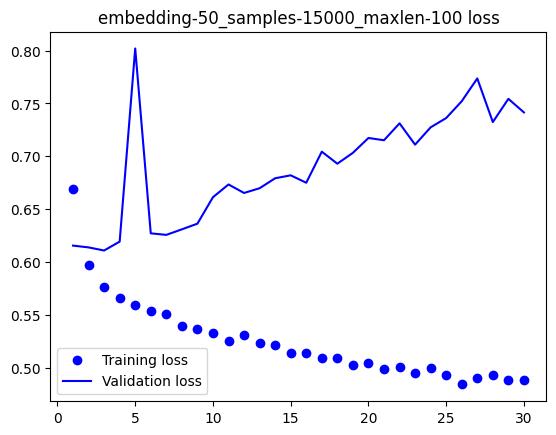

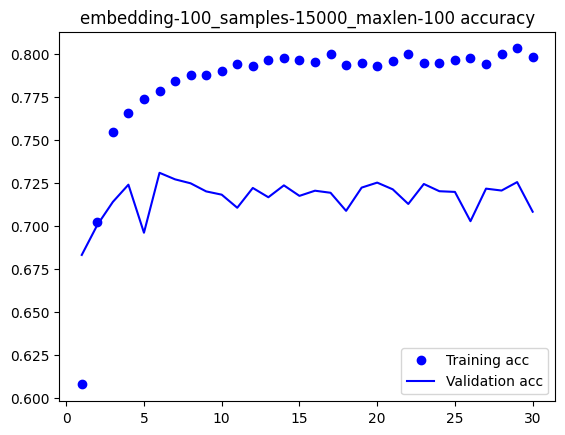

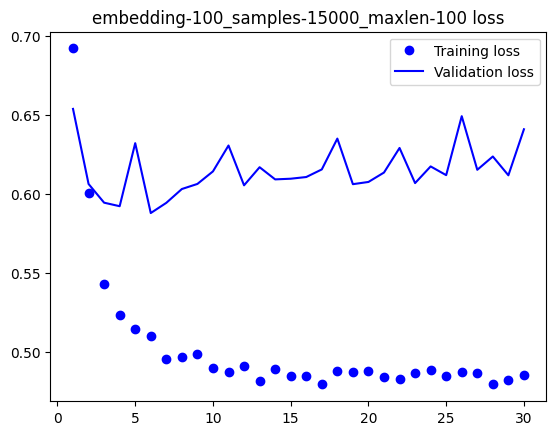

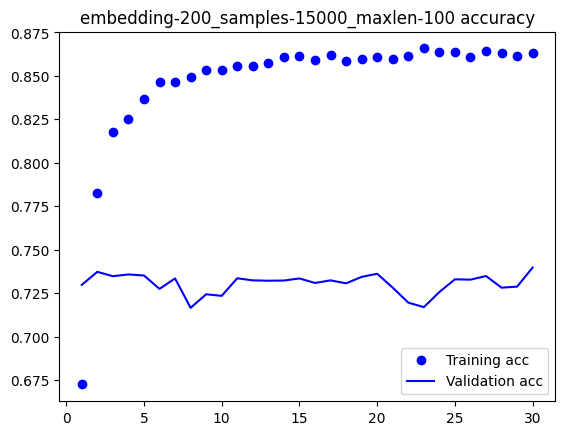

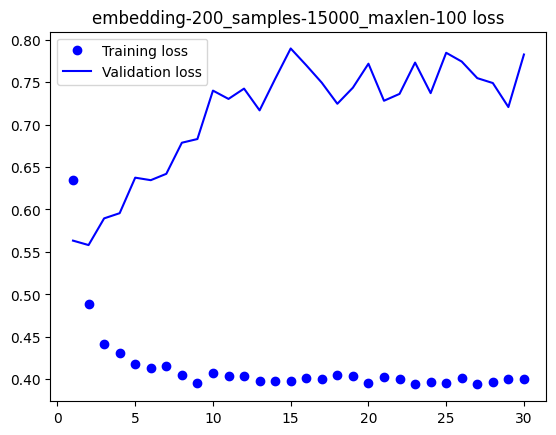

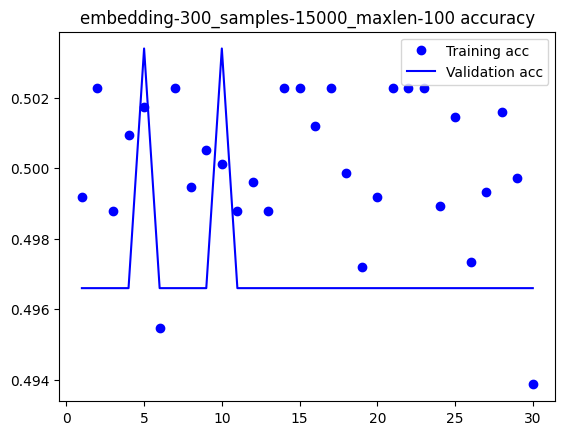

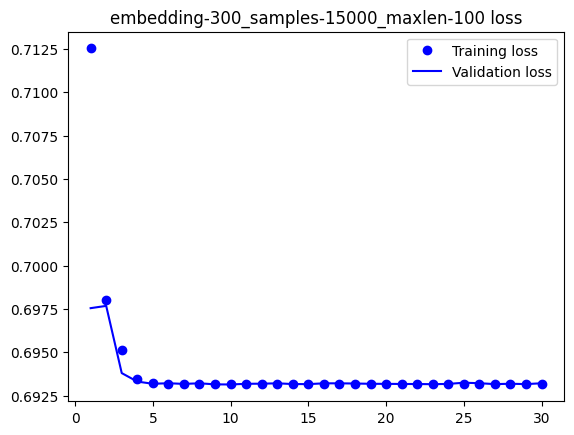

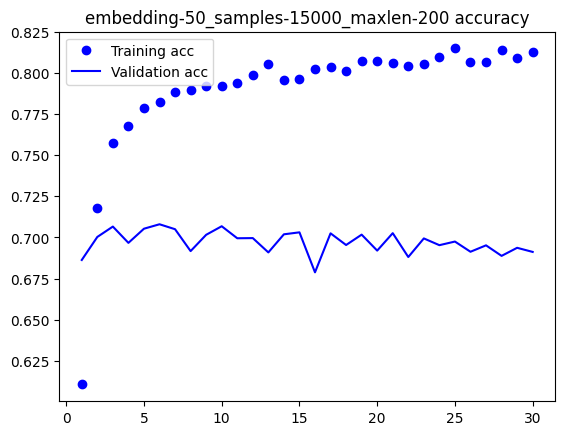

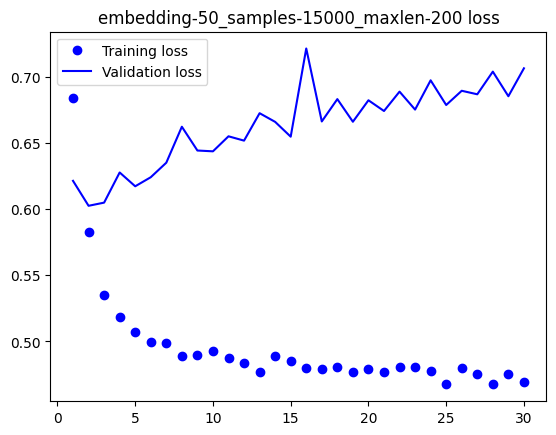

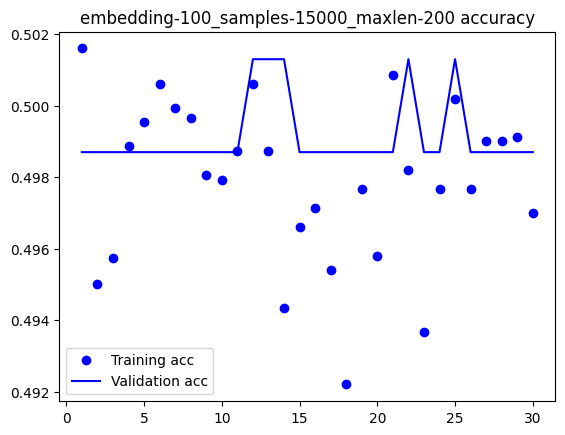

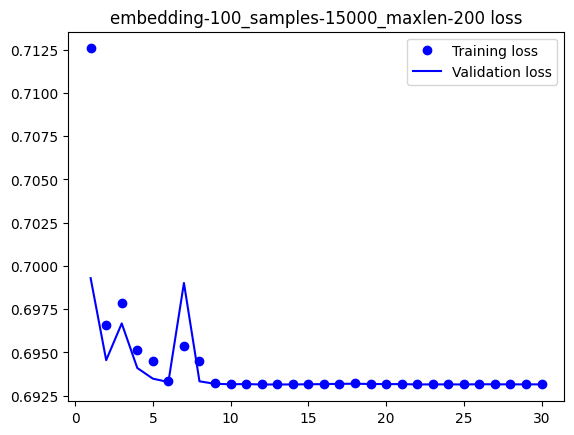

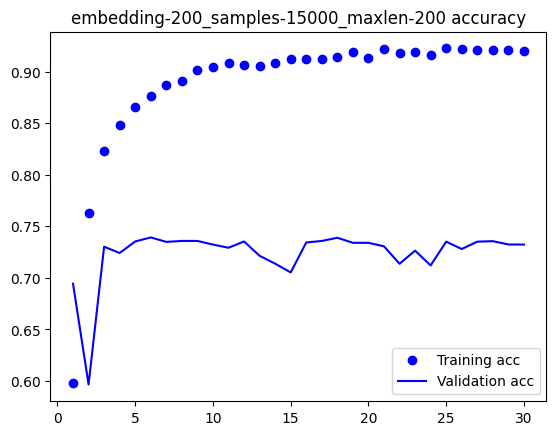

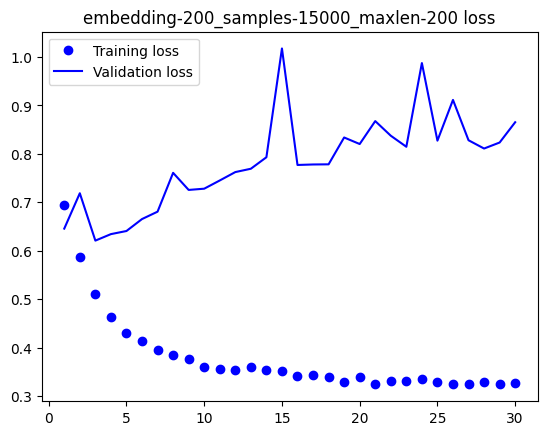

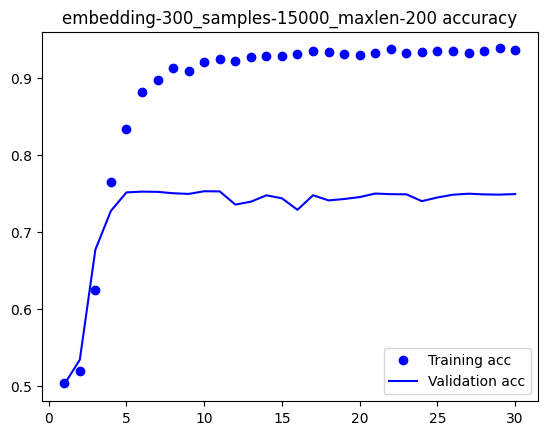

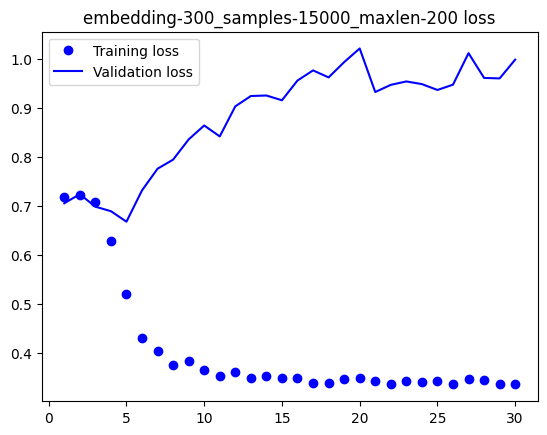

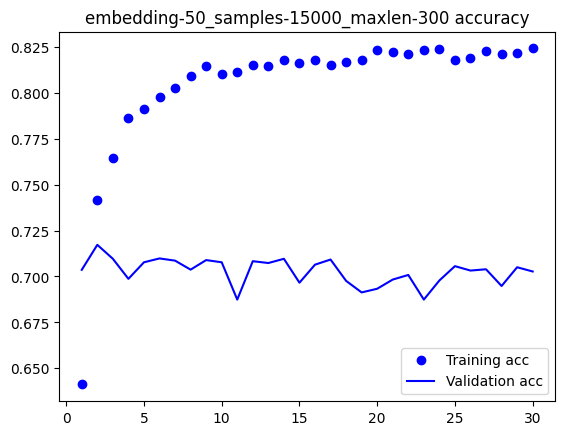

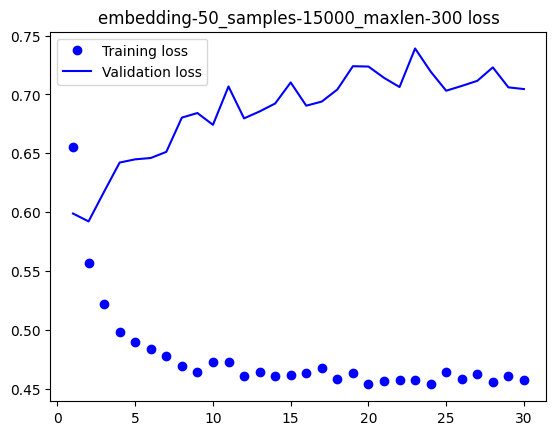

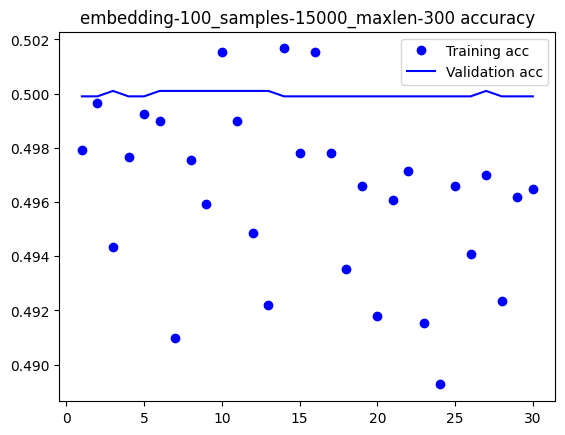

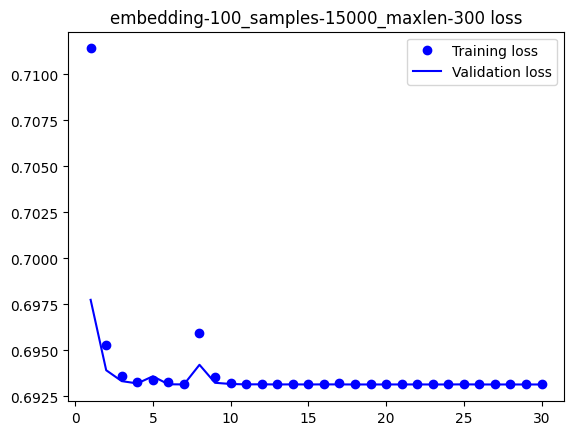

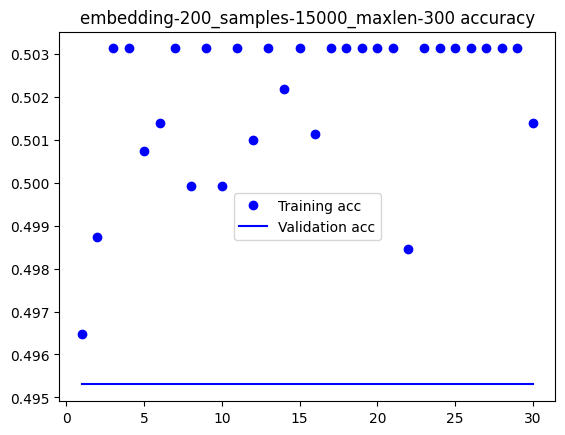

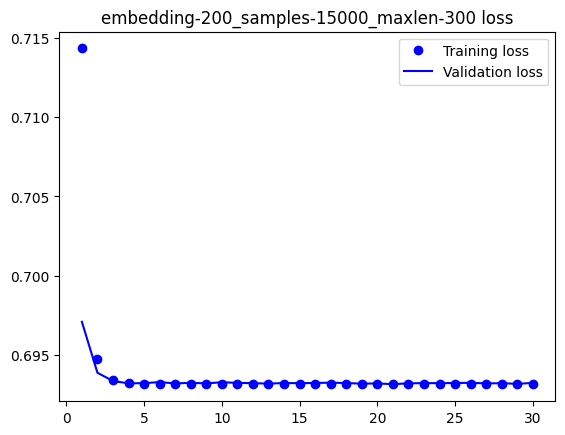

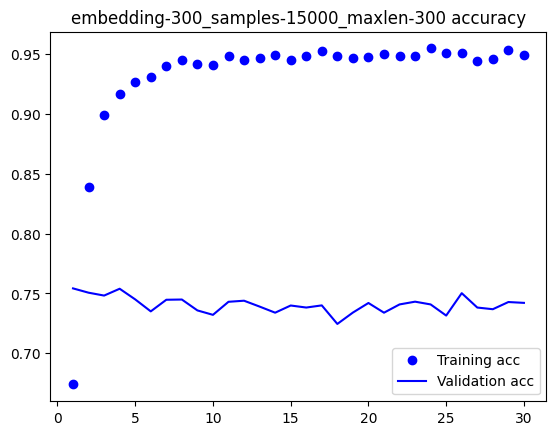

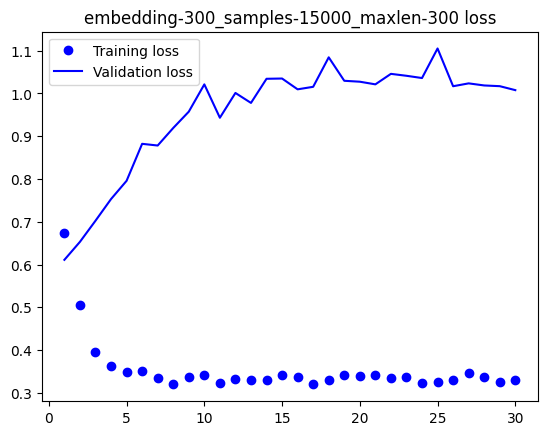

In [18]:
for model, history in zip(models, histories):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(f'{model.name} accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{model.name} loss')
    plt.legend()

    plt.show()

In [16]:
# find the best model
best_model = models[np.argmax([history.history['val_acc'][-1] for history in histories])]
best_model.save('best_model.weights.h5')

In [17]:
# best model params
params = best_model.name.split('_')
params = {param.split('-')[0]: int(param.split('-')[1]) for param in params}

x_train, y_train, x_val, y_val, word_index = prepare_data(data=texts, labels=labels, training_samples=params['samples'], num_words=10000, maxlen=params['maxlen'])

# evaluate the best model
loss, accuracy = best_model.evaluate(x_val, y_val)
print(f'Best model: {best_model.name}')
print(f'Loss: {loss}, Accuracy: {accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8905 - loss: 0.5403
Best model: embedding-300_samples-15000_maxlen-200
Loss: 0.5447081923484802, Accuracy: 0.8873999714851379


Najlepszym modelem okazał się model korzystający z 15000 próbek treningowych (co nie jest zaskoczeniem, im więcej danych tym lepiej) o maksymalnej długości 200 i 300 wymiarowym embeddingiem. Osiąga on dokładność na zbiorze walidacyjnym na poziomie 0.89%, co jest zadowalającym wynikiem, biorąc pod uwagę jego prostotę.